# Imports

In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import lead, avg, mean, stddev, countDistinct, when, col, udf, month, lit, median as _median
from pyspark.sql.types import FloatType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import RegressionMetrics, BinaryClassificationMetrics
from xgboost.spark import SparkXGBRegressor, SparkXGBClassifier


import xgboost as xgb
import shap

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# PySpark Initialization

In [2]:


spark = SparkSession.builder\
        .master("local")\
        .appName("GSOD")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

24/03/09 19:38:18 WARN Utils: Your hostname, Mayanks-MacBook-Pro-4.local resolves to a loopback address: 127.0.0.1; using 192.168.1.139 instead (on interface en0)
24/03/09 19:38:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/09 19:38:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/09 19:38:19 WARN Utils: Service 'SparkUI' could not bind on port 4050. Attempting port 4051.


# Data Loading

In [3]:
df = spark.read.format("csv").load("gsod-2023.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- stn: string (nullable = true)
 |-- wban: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- mo: integer (nullable = true)
 |-- da: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: integer (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: integer (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: integer (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: integer (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: integer (nullable = true)
 |-- wdsp: double (nullable = true)
 |-- count_wdsp: integer (nullable = true)
 |-- mxpsd: double (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp:

In [4]:
df.show(5)

24/03/09 19:38:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+-----+----------+----+---+---+----+----------+----+----------+------+---------+----+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|   stn| wban|      date|year| mo| da|temp|count_temp|dewp|count_dewp|   slp|count_slp| stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust| max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----------+----+---+---+----+----------+----+----------+------+---------+----+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|010020|99999|2023-11-14|2023| 11| 14| 3.6|         4|-1.0|         4|1017.7|        4|16.4|        4|999.9|          0|12.9|         4| 16.7| 18.5| 6.6|    NULL| 1.0|    NULL| 0.0|        I|999.9|  0| 

In [5]:

# List of columns with their respective missing value indicators
missing_value_indicators = {
    'temp': 9999.9, 'dewp': 9999.9, 'slp': 9999.9, 'stp': 9999.9,
    'visib': 999.9, 'wdsp': 999.9, 'mxpsd': 999.9, 'gust': 999.9,
    'max': 9999.9, 'min': 9999.9, 'prcp': 99.99, 'sndp': 999.9,
}

# Replace placeholder values with None (which represents null in PySpark)
for column, indicator in missing_value_indicators.items():
    df = df.withColumn(column, when(col(column) == indicator, None).otherwise(col(column)))

In [6]:
# Assuming other columns have missing values represented by 'null' or 'None'
missing_counts = {column: df.filter(col(column).isNull()).count() for column in df.columns}

# View the count of missing values for all columns in df
for column, count in missing_counts.items():
    print(f"{column}: {count} missing values")

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=37333Kb max_used=37345Kb free=93738Kb
 bounds [0x00000001071e0000, 0x00000001096a0000, 0x000000010f1e0000]
 total_blobs=12974 nmethods=12034 adapters=850
 compilation: disabled (not enough contiguous free space left)


stn: 0 missing values
wban: 0 missing values
date: 0 missing values
year: 0 missing values
mo: 0 missing values
da: 0 missing values
temp: 0 missing values
count_temp: 0 missing values
dewp: 183725 missing values
count_dewp: 0 missing values
slp: 1386896 missing values
count_slp: 0 missing values
stp: 0 missing values
count_stp: 0 missing values
visib: 1071834 missing values
count_visib: 0 missing values
wdsp: 142206 missing values
count_wdsp: 0 missing values
mxpsd: 178903 missing values
gust: 2972264 missing values
max: 2214 missing values
flag_max: 2493618 missing values
min: 3079 missing values
flag_min: 2462555 missing values
prcp: 327442 missing values
flag_prcp: 327442 missing values
sndp: 3758174 missing values
fog: 0 missing values
rain_drizzle: 0 missing values
snow_ice_pellets: 0 missing values
hail: 0 missing values
thunder: 0 missing values
tornado_funnel_cloud: 0 missing values


# Visualization

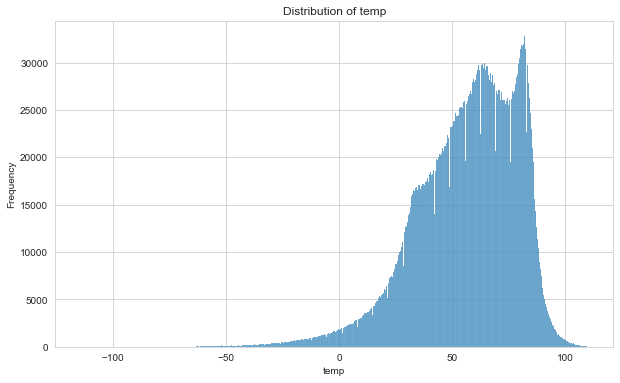

In [7]:
# For the plot, use Seaborn to plot the distribution of the first numerical feature
sns.set_style("whitegrid")
feature_to_plot = 'temp'
pdf = df.select(feature_to_plot).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(pdf[feature_to_plot].dropna(), kde=False)
plt.title(f'Distribution of {feature_to_plot}')
plt.xlabel(feature_to_plot)
plt.ylabel('Frequency')
plt.show()

# Feature Selection

In [8]:
# List of columns to drop
columns_to_drop = ['dewp', 'wban', 'gust', 'flag_max', 'flag_min', 'flag_prcp', 'sndp', 'slp']

# Drop the columns
df = df.drop(*columns_to_drop)

In [9]:
numerical_columns = [
    'temp',           # Mean temperature
    # 'dewp',           # Mean dew point
    # 'slp',            # Mean sea level pressure
    'stp',            # Mean station pressure
    'visib',          # Mean visibility
    'wdsp',           # Mean wind speed
    'mxpsd',          # Maximum sustained wind speed
    'max',            # Maximum temperature
    'min',            # Minimum temperature
    'prcp',           # Total precipitation
    # Number of values that were used to compute the mean
    'count_temp',     
    'count_dewp',     
    'count_slp',      
    'count_stp',      
    'count_visib',    
    'count_wdsp'      
]

for column in numerical_columns:
    # Calculate mean, standard deviation, and distinct count
    stats = df.select(
        mean(col(column)).alias('mean'),
        stddev(col(column)).alias('stddev'),
        countDistinct(col(column)).alias('distinct_count')
    ).collect()[0]
    
    # Calculate median
    median_value = df.stat.approxQuantile(column, [0.5], 0.05)[0]

    # Calculate mode - mode may not be accurate if the dataset is very large due to Spark's distributed nature.
    mode_value = df.groupBy(column).count().orderBy('count', ascending=False).first()[column]

    # Print the statistics in one line
    print(f"{column} | Mean: {stats['mean']:.2f} | StdDev: {stats['stddev']:.2f} | Median: {median_value:.2f} | Mode: {mode_value} | Distinct Count: {stats['distinct_count']}")


temp | Mean: 56.49 | StdDev: 22.66 | Median: 58.50 | Mode: 81.7 | Distinct Count: 2127


stp | Mean: 703.23 | StdDev: 429.90 | Median: 968.60 | Mode: 999.9 | Distinct Count: 5047


visib | Mean: 9.80 | StdDev: 6.21 | Median: 8.40 | Mode: None | Distinct Count: 577


wdsp | Mean: 6.13 | StdDev: 4.34 | Median: 5.10 | Mode: None | Distinct Count: 629


mxpsd | Mean: 11.50 | StdDev: 6.36 | Median: 9.90 | Mode: 9.9 | Distinct Count: 409


max | Mean: 66.17 | StdDev: 23.77 | Median: 70.00 | Mode: 86.0 | Distinct Count: 1263


min | Mean: 47.28 | StdDev: 22.54 | Median: 49.10 | Mode: 75.2 | Distinct Count: 1198


prcp | Mean: 0.07 | StdDev: 0.29 | Median: 0.00 | Mode: 0.0 | Distinct Count: 909


count_temp | Mean: 18.39 | StdDev: 7.47 | Median: 24.00 | Mode: 24 | Distinct Count: 21


count_dewp | Mean: 17.34 | StdDev: 8.26 | Median: 24.00 | Mode: 24 | Distinct Count: 22


count_slp | Mean: 10.46 | StdDev: 9.89 | Median: 8.00 | Mode: 0 | Distinct Count: 22


count_stp | Mean: 11.67 | StdDev: 10.06 | Median: 8.00 | Mode: 24 | Distinct Count: 22


count_visib | Mean: 12.50 | StdDev: 10.13 | Median: 11.00 | Mode: 24 | Distinct Count: 22


count_wdsp | Mean: 17.59 | StdDev: 8.08 | Median: 24.00 | Mode: 24 | Distinct Count: 22


In [10]:

categorical_columns = [
    'fog',                  # Fog 
    'rain_drizzle',         # Rain or drizzle 
    'snow_ice_pellets',     # Snow or ice pellets 
    'hail',                 # Hail 
    'thunder',              # Thunder
    'tornado_funnel_cloud', # Tornado or funnel cloud 
    # Flags are categorical and indicate data quality or source
    # 'flag_max',             
    # 'flag_min',             
    # 'flag_prcp',            
    # Time-related fields can be used for time series analysis but are not direct features themselves
    # 'year',                 
    # 'mo',                   
    # 'da'                    
]

# For categorical features, count the number of distinct categories
for column in categorical_columns:
    distinct_count = df.select(countDistinct(col(column)).alias('distinct_count')).collect()
    print(f"{column} | Unique Categories: {distinct_count[0]['distinct_count']}")

fog | Unique Categories: 2


rain_drizzle | Unique Categories: 2


snow_ice_pellets | Unique Categories: 2


hail | Unique Categories: 2


thunder | Unique Categories: 2


tornado_funnel_cloud | Unique Categories: 2


# Data Imputation

In [11]:
def MedianImputer(df, column_name):
    """
    Imputes missing values in a DataFrame column with the median value grouped by the station,
    and uses the global median as a fallback if all values for a feature at a station are None.
    Reports the number of values imputed using station-specific and global median.

    :param df: Spark DataFrame containing the column to impute.
    :param column_name: Name of the column to impute.
    """
    
    initial_missing_count = df.filter(col(column_name).isNull()).count()

    # Calculate global median for the fallback
    global_median = df.agg(_median(col(column_name)).alias('global_median')).collect()[0]['global_median']

    # Group by 'stn' and calculate median for each group
    median_values = df.groupBy('stn').agg(_median(col(column_name)).alias('median')).collect()

    # Initialize counter for imputation tracking
    station_imputed_count = 0
    global_imputed_count = 0

    # Create a dictionary to map each 'stn' to its median value, including a global fallback
    median_map = {}
    for row in median_values:
        if row['median'] is not None:
            median_map[row['stn']] = row['median']
        else:
            median_map[row['stn']] = global_median
            global_imputed_count += df.filter((col('stn') == row['stn']) & col(column_name).isNull()).count()

    # Use global median if there are stations not covered in median_values
    median_map['global'] = global_median

    # User defined function to return the median based on the 'stn' value, falling back to global median
    def get_median(stn):
        return median_map.get(stn, global_median)

    # Register the function as a UDF
    median_udf = udf(get_median, FloatType())

    # Apply the UDF to the DataFrame to impute missing values, tracking the number of imputations
    df_with_imputation_flag = df.withColumn(column_name+'_imputed', when(col(column_name).isNull(), median_udf(col('stn'))).otherwise(col(column_name))) \
                                .withColumn("imputed_flag", when(col(column_name).isNull(), 1).otherwise(0))

    station_imputed_count = initial_missing_count - global_imputed_count

    # Drop the original column and rename the imputed column to the original column name, remove the imputation flag
    df = df_with_imputation_flag.drop(column_name) \
                                .drop("imputed_flag") \
                                .withColumnRenamed(column_name+'_imputed', column_name)

    print(f"Imputed {station_imputed_count} missing values using station median and {global_imputed_count} missing values using global median in '{column_name}'.")

    return df




def ProximityMedian(df, column, initial_num_days, max_days, fallback_strategy='median'):
    """
    Imputes missing values in a DataFrame column by taking the average of the values
    num_days before and after the date of the missing observation, for the same station.
    The num_days is increased progressively until there are no more missing values 
    or until the max_days is reached. If imputation still fails after reaching max_days, 
    a fallback strategy is applied.

    :param df: Spark DataFrame containing the column to impute.
    :param column: Name of the column to impute.
    :param initial_num_days: Initial number of days before and after to consider for the average.
    :param max_days: Maximum number of days to increase the window for imputation.
    :param fallback_strategy: Strategy to use if the imputation is not successful ('median' or 'mean').
    :returns: DataFrame with the imputed column.
    """
    num_days = initial_num_days
    original_missing_count = df.filter(col(column).isNull()).count()
    
    # Perform the proximity mean imputation
    while num_days <= max_days and original_missing_count > 0:
        windowSpec = Window.partitionBy('stn').orderBy('date').rowsBetween(-num_days, num_days)
        df = df.withColumn(
            f"{column}_imputed",
            when(
                col(column).isNull(),
                avg(col(column)).over(windowSpec)
            ).otherwise(col(column))
        )
        
        missing_count_after = df.filter(col(f"{column}_imputed").isNull()).count()
        if missing_count_after == 0:
            break
        num_days *= 2  # Increase the window size for the next iteration

    # If there are still missing values after the maximum window size is reached, use the fallback strategy
    if missing_count_after > 0:
        fallback_value = df.stat.approxQuantile(column, [0.5], 0.001)[0] if fallback_strategy == 'median' else df.agg(avg(col(column))).first()[0]
        df = df.withColumn(
            f"{column}_imputed",
            when(
                col(f"{column}_imputed").isNull(),
                lit(fallback_value)
            ).otherwise(col(f"{column}_imputed"))
        )
    
    final_df = df.drop(column).withColumnRenamed(f"{column}_imputed", column)
    
    # Print a summary of what happened
    print(f"ProximityMedian imputation for '{column}':"
          f" Initial Missing: {original_missing_count},"
          f" Remaining Missing (after ProximityMedian): {missing_count_after},"
          f" Filled the rest with strategy: '{fallback_strategy}'.")

    return final_df


def ImputeTempWithSeasonalMedian(df, column, initial_num_days=7, max_days=31):
    """
    Imputes missing values for a given temperature column ('max' or 'min') in a DataFrame
    by using the median temperature value for the corresponding station ('stn') and month.
    If this fails to impute all missing values, falls back to the ProximityMean method.

    Args:
    df (DataFrame): The Spark DataFrame containing weather data.
    column (str): The name of the temperature column to impute ('max' or 'min').
    initial_num_days (int): Starting number of days for proximity mean imputation.
    max_days (int): Maximum number of days for expanding the window in proximity mean imputation.

    Returns:
    DataFrame: The DataFrame with missing temperature values imputed.
    """

    initial_missing_count = df.filter(col(column).isNull()).count()
    
    # Calculate median temperature grouped by 'stn' and 'mo' (month)
    median_temp = df.groupBy('stn', month(df.date).alias('mo')).agg(_median(col(column)).alias('median_temp'))
    
    # Join the median_temp DataFrame with the original DataFrame based on 'stn' and 'mo'
    df = df.join(median_temp, (df.stn == median_temp.stn) & (month(df.date) == median_temp.mo), 'left_outer')

    # Impute missing values with the corresponding median_temp
    df = df.withColumn(column, when(col(column).isNull(), col('median_temp')).otherwise(col(column)))

    final_missing_count = df.filter(col(column).isNull()).count()
    
    print(f"Imputed {initial_missing_count - final_missing_count} missing values in '{column}' using seasonal median by station and month.")

    # Drop the extra columns used for the join
    df = df.drop(median_temp.stn).drop(median_temp.mo).drop('median_temp')

    if final_missing_count != 0:
        # Fallback to ProximityMean if not all values were imputed
        df = ProximityMedian(df, column, initial_num_days, max_days)
        print(f"Used ProximityMedian as a fallback for remaining {final_missing_count} missing values.")
    
    return df

In [12]:
imputation_strategy = {
    # 'dewp': lambda df: MedianImputer(df, 'dewp'),
    # 'slp': lambda df: MedianImputer(df, 'slp'),
    'visib': lambda df: ProximityMedian(df, 'visib', initial_num_days=7, max_days=30, fallback_strategy='median'),
    'wdsp': lambda df: ProximityMedian(df, 'wdsp', initial_num_days=7, max_days=30, fallback_strategy='median'),
    'mxpsd': lambda df: ProximityMedian(df, 'mxpsd', initial_num_days=7, max_days=30, fallback_strategy='median'),
    'prcp': lambda df: df.na.fill({'prcp': 0}),  # Zero imputation for precipitation
    'max': lambda df: ImputeTempWithSeasonalMedian(df, 'max'),
    'min': lambda df: ImputeTempWithSeasonalMedian(df, 'min')
}


In [13]:
for column, impute_function in imputation_strategy.items():
    df = impute_function(df)

ProximityMedian imputation for 'visib': Initial Missing: 1071834, Remaining Missing (after ProximityMedian): 950283, Filled the rest with strategy: 'median'.


ProximityMedian imputation for 'wdsp': Initial Missing: 142206, Remaining Missing (after ProximityMedian): 74652, Filled the rest with strategy: 'median'.


ProximityMedian imputation for 'mxpsd': Initial Missing: 178903, Remaining Missing (after ProximityMedian): 79316, Filled the rest with strategy: 'median'.


Imputed 2093 missing values in 'max' using seasonal median by station and month.


ProximityMedian imputation for 'max': Initial Missing: 121, Remaining Missing (after ProximityMedian): 10, Filled the rest with strategy: 'median'.
Used ProximityMedian as a fallback for remaining 121 missing values.


Imputed 2957 missing values in 'min' using seasonal median by station and month.


ProximityMedian imputation for 'min': Initial Missing: 122, Remaining Missing (after ProximityMedian): 12, Filled the rest with strategy: 'median'.
Used ProximityMedian as a fallback for remaining 122 missing values.


In [14]:
df.show(5)

+----------+----+---+---+----+----------+----------+---------+-----+---------+-----------+----------+----+---+------------+----------------+----+-------+--------------------+-----+-----------------+-----------------+----+------+----+
|      date|year| mo| da|temp|count_temp|count_dewp|count_slp|  stp|count_stp|count_visib|count_wdsp|prcp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|visib|             wdsp|            mxpsd| max|   stn| min|
+----------+----+---+---+----+----------+----------+---------+-----+---------+-----------+----------+----+---+------------+----------------+----+-------+--------------------+-----+-----------------+-----------------+----+------+----+
|2023-01-13|2023|  1| 13|28.6|         7|         7|        7|988.2|        7|          0|         7| 0.0|  0|           0|               0|   0|      0|                   0|  8.8|             23.4|             31.9|28.8|010060|28.4|
|2023-02-14|2023|  2| 14|28.7|         8|         8|        8|99

In [15]:
# Assuming other columns have missing values represented by 'null' or 'None'
missing_counts_2 = {column: df.filter(col(column).isNull()).count() for column in df.columns}

# View the count of missing values for all columns in df
for column, count in missing_counts_2.items():
    print(f"{column}: {count} missing values")

24/03/09 19:58:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


date: 0 missing values
year: 0 missing values
mo: 0 missing values
da: 0 missing values
temp: 0 missing values
count_temp: 0 missing values
count_dewp: 0 missing values
count_slp: 0 missing values
stp: 0 missing values
count_stp: 0 missing values
count_visib: 0 missing values
count_wdsp: 0 missing values
prcp: 0 missing values
fog: 0 missing values
rain_drizzle: 0 missing values
snow_ice_pellets: 0 missing values
hail: 0 missing values
thunder: 0 missing values
tornado_funnel_cloud: 0 missing values
visib: 0 missing values
wdsp: 0 missing values
mxpsd: 0 missing values
max: 0 missing values
stn: 0 missing values
min: 0 missing values


In [16]:
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- mo: integer (nullable = true)
 |-- da: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: integer (nullable = true)
 |-- count_dewp: integer (nullable = true)
 |-- count_slp: integer (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: integer (nullable = true)
 |-- count_visib: integer (nullable = true)
 |-- count_wdsp: integer (nullable = true)
 |-- prcp: double (nullable = false)
 |-- fog: integer (nullable = true)
 |-- rain_drizzle: integer (nullable = true)
 |-- snow_ice_pellets: integer (nullable = true)
 |-- hail: integer (nullable = true)
 |-- thunder: integer (nullable = true)
 |-- tornado_funnel_cloud: integer (nullable = true)
 |-- visib: double (nullable = true)
 |-- wdsp: double (nullable = true)
 |-- mxpsd: double (nullable = true)
 |-- max: double (nullable = true)
 |-- stn: string (nullable = true)
 |-- min: double (nullable = true)



# Vectorization

In [17]:
# Process categorical columns with StringIndexer and OneHotEncoder
for categorical_col in categorical_columns:
    string_indexer = StringIndexer(inputCol=categorical_col, outputCol=categorical_col + "_index")
    df = string_indexer.fit(df).transform(df)
    encoder = OneHotEncoder(inputCol=categorical_col + "_index", outputCol=categorical_col + "_vec")
    df = encoder.fit(df).transform(df)


In [18]:
# Create a window spec
windowSpec = Window.partitionBy("stn").orderBy("date")

# For regression, shift 'max' temperature by one day to predict next day's temperature
df = df.withColumn("next_day_max", lead("max").over(windowSpec))

# For classification, shift 'rain_drizzle' by one day to predict rain/drizzle for the next day
df = df.withColumn("next_day_rain", lead("rain_drizzle").over(windowSpec))

# Filter out the rows with null 'next_day_max' or 'next_day_rain' as these will be our labels
df_filtered = df.filter(df.next_day_max.isNotNull() & df.next_day_rain.isNotNull())

# Assemble numerical features
numerical_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")
df_numerical_assembled = numerical_assembler.transform(df_filtered)

In [19]:
df_numerical_assembled.show(3)

+----------+----+---+---+----+----------+----------+---------+-----+---------+-----------+----------+----+---+------------+----------------+----+-------+--------------------+-----+-----------------+-----------------+----+------+----+---------+-------------+------------------+----------------+----------------------+--------------------+----------+-------------+-------------+-------------+--------------------------+------------------------+------------+-------------+--------------------+
|      date|year| mo| da|temp|count_temp|count_dewp|count_slp|  stp|count_stp|count_visib|count_wdsp|prcp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|visib|             wdsp|            mxpsd| max|   stn| min|fog_index|      fog_vec|rain_drizzle_index|rain_drizzle_vec|snow_ice_pellets_index|snow_ice_pellets_vec|hail_index|     hail_vec|thunder_index|  thunder_vec|tornado_funnel_cloud_index|tornado_funnel_cloud_vec|next_day_max|next_day_rain|  numerical_features|
+----------+----+-

In [20]:
# StandardScaler for numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")
df_scaled_numerical = scaler.fit(df_numerical_assembled).transform(df_numerical_assembled)

# Assemble scaled numerical features with one-hot encoded categorical features
final_assembler_inputs = [c + "_vec" for c in categorical_columns] + ["scaled_numerical_features"]
final_assembler = VectorAssembler(inputCols=final_assembler_inputs, outputCol="features")
df_final = final_assembler.transform(df_scaled_numerical)

In [21]:
df_final.show(3)

+----------+----+---+---+----+----------+----------+---------+-----+---------+-----------+----------+----+---+------------+----------------+----+-------+--------------------+-----+-----------------+-----------------+----+------+----+---------+-------------+------------------+----------------+----------------------+--------------------+----------+-------------+-------------+-------------+--------------------------+------------------------+------------+-------------+--------------------+-------------------------+--------------------+
|      date|year| mo| da|temp|count_temp|count_dewp|count_slp|  stp|count_stp|count_visib|count_wdsp|prcp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|visib|             wdsp|            mxpsd| max|   stn| min|fog_index|      fog_vec|rain_drizzle_index|rain_drizzle_vec|snow_ice_pellets_index|snow_ice_pellets_vec|hail_index|     hail_vec|thunder_index|  thunder_vec|tornado_funnel_cloud_index|tornado_funnel_cloud_vec|next_day_max|next_da

# Train-Test Split

In [22]:
# Split the data into training and test sets
(train_data, test_data) = df_final.randomSplit([0.8, 0.2])

In [23]:
train_data.select('features').take(3)

[Row(features=DenseVector([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.6675, 2.2703, 5.6867, 0.0, 0.5584, -2.3281, -2.7831, 0.0, 1.0718, 0.9682, 0.809, 0.7956, 0.7894, 0.9898])),
 Row(features=DenseVector([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.6145, 2.1298, 3.5474, 0.0, 1.5796, -2.2439, -2.8319, 0.0, 1.0718, 0.9682, 0.809, 0.7956, 0.7894, 0.9898])),
 Row(features=DenseVector([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.1817, 2.3047, 2.7062, 0.0, 0.343, -1.9661, -2.5123, 0.0, 1.0718, 0.9682, 0.809, 0.7956, 0.7894, 0.9898]))]

# ML - Regression - Predict next day max temperature 

In [24]:
regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="next_day_max", metricName="rmse")

## Linear Regression (baseline)

In [25]:
# Regression model: predict next day's maximum temperature
regressor = LinearRegression(featuresCol="features", labelCol="next_day_max")
regression_model = regressor.fit(train_data)

# Linear Regression - Predict and Evaluate
lr_predictions = regression_model.transform(test_data)
lr_rmse = regression_evaluator.evaluate(lr_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")

24/03/09 20:08:45 WARN Instrumentation: [a9c8a9b6] regParam is zero, which might cause numerical instability and overfitting.
24/03/09 20:08:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/03/09 20:09:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression RMSE: 6.210326130400553


In [26]:
lr_predictions.show(2)

+----------+----+---+---+-----+----------+----------+---------+-----+---------+-----------+----------+----+---+------------+----------------+----+-------+--------------------+-----+----+------------------+-----+------+-----+---------+-------------+------------------+----------------+----------------------+--------------------+----------+-------------+-------------+-------------+--------------------------+------------------------+------------+-------------+--------------------+-------------------------+--------------------+-------------------+
|      date|year| mo| da| temp|count_temp|count_dewp|count_slp|  stp|count_stp|count_visib|count_wdsp|prcp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|visib|wdsp|             mxpsd|  max|   stn|  min|fog_index|      fog_vec|rain_drizzle_index|rain_drizzle_vec|snow_ice_pellets_index|snow_ice_pellets_vec|hail_index|     hail_vec|thunder_index|  thunder_vec|tornado_funnel_cloud_index|tornado_funnel_cloud_vec|next_day_max|next_

In [27]:
predictions_and_labels_rdd = lr_predictions.select(col("prediction"), col("next_day_max")).rdd.map(lambda row: (row[0], row[1]))

# Instantiate RegressionMetrics based on the RDD
regression_metrics = RegressionMetrics(predictions_and_labels_rdd)

# Now you can use various metrics provided by RegressionMetrics
print(f"RMSE: {regression_metrics.rootMeanSquaredError}")
print(f"MSE: {regression_metrics.meanSquaredError}")
print(f"MAE: {regression_metrics.meanAbsoluteError}")
print(f"R2: {regression_metrics.r2}")


/Users/mj/conda_env/tf/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE: 6.210326130400553
MSE: 38.5681506459359
MAE: 4.1478866853106195
R2: 0.9316811040993814


## XGBoostRegressor

In [28]:
# XGBoost Regression - Train and Evaluate
xgboost_regressor = SparkXGBRegressor(features_col="features", label_col="next_day_max")
xgb_regression_model = xgboost_regressor.fit(train_data)
xgbr_predictions = xgb_regression_model.transform(test_data)
# xgb_lr_rmse = regression_evaluator.evaluate(xgbr_predictions)
# print(f"XGBoost Regression RMSE: {xgb_lr_rmse}")

2024-03-09 20:19:02,937 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[20:21:09] task 0 got new rank 0                                    (0 + 1) / 1]
2024-03-09 20:21:27,076 INFO XGBoost-PySpark: _fit Finished xgboost training!   


In [29]:
predictions_and_labels_rdd = xgbr_predictions.select(col("prediction"), col("next_day_max")).rdd.map(lambda row: (row[0], row[1]))

# Instantiate RegressionMetrics based on the RDD
regression_metrics = RegressionMetrics(predictions_and_labels_rdd)

# Now you can use various metrics provided by RegressionMetrics
print(f"RMSE: {regression_metrics.rootMeanSquaredError}")
print(f"MSE: {regression_metrics.meanSquaredError}")
print(f"MAE: {regression_metrics.meanAbsoluteError}")
print(f"R2: {regression_metrics.r2}")


2024-03-09 20:22:52,477 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:23:05,111 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:23:20,862 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:23:34,624 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:23:47,261 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


RMSE: 5.860180170342648
MSE: 34.34171162887719
MAE: 3.978825668278152
R2: 0.9391677385996325


# ML - Classification - Predict next day rain (binary)

In [30]:
# For Classification Evaluation (Random Forest and XGBoost)
classification_evaluator = MulticlassClassificationEvaluator(labelCol="next_day_rain", predictionCol="prediction", metricName="accuracy")

## Random Forest Classifier (baseline)

In [31]:
# # Classification model: predict if there will be rain/drizzle the next day
# classifier = RandomForestClassifier(featuresCol="features", labelCol="next_day_rain")
# classification_model = classifier.fit(train_data)
# # Random Forest Classifier - Predict and Evaluate
# rf_predictions = classification_model.transform(test_data)
# rf_accuracy = classification_evaluator.evaluate(rf_predictions)
# print(f"Random Forest Classifier Accuracy: {rf_accuracy}")

In [32]:
# # Random Forest feature importances
# rf_feature_importances = classification_model.featureImportances.toArray()
# print("Random Forest Feature Importances:")
# for i, importance in enumerate(rf_feature_importances):
#     print(f"Feature {i + 1}: {importance}")

## XGBoostClassifier

In [33]:
# XGBoost Classification - Train and Evaluate
xgboost_classifier = SparkXGBClassifier(features_col="features", label_col="next_day_rain")
xgb_classification_model = xgboost_classifier.fit(train_data)
xgbc_predictions = xgb_classification_model.transform(test_data)

2024-03-09 20:27:29,104 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[20:29:49] task 0 got new rank 0                                    (0 + 1) / 1]
2024-03-09 20:30:25,558 INFO XGBoost-PySpark: _fit Finished xgboost training!   


In [34]:
xgbc_accuracy = classification_evaluator.evaluate(xgbc_predictions)
predictions_and_labels_rdd = xgbc_predictions.select(
    col("prediction").cast("double"),  # Cast prediction to DoubleType
    col("next_day_rain").cast("double")  # Cast next_day_rain to DoubleType
).rdd.map(lambda row: (row[0], row[1]))

# Instantiate RegressionMetrics based on the RDD
binary_classification_metrics = BinaryClassificationMetrics(predictions_and_labels_rdd)

# Now you can use various metrics provided by RegressionMetrics
print(f"XGBoost Classifier Accuracy: {xgbc_accuracy}")
print(f"areaUnderPR: {binary_classification_metrics.areaUnderPR}")
print(f"areaUnderROC: {binary_classification_metrics.areaUnderROC}")

2024-03-09 20:32:00,143 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:32:16,723 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:32:33,426 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:32:45,211 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:34:19,123 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


XGBoost Classifier Accuracy: 0.8054632811229071


2024-03-09 20:34:29,619 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:34:42,514 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:34:56,598 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-03-09 20:35:09,129 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


areaUnderPR: 0.5324203800955083
areaUnderROC: 0.6949216836361061


## SHAP for Classification

In [35]:
# Save the PySpark XGBoost model
model_path = "./xgb_classification_model"
xgb_classification_model.write().overwrite().save(model_path)

# Load the model using Python's XGBoost
xgb_model = xgb.Booster()
xgb_model.load_model(model_path + '/model/part-00000')

# Convert the test data to Pandas DataFrame
X_test_pandas = test_data.select("features").toPandas()
print(X_test_pandas.head())

                                            features
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.755831784946...
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.296526487455...
2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.018293470706...
3  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.894634352151...
4  [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, -1.558988173215...


In [40]:
# Assume 'numerical_columns' is a list of your original numerical feature names
scaled_feature_names = ["scaled_" + col for col in numerical_columns]

# Categorical feature names after one-hot encoding
categorical_feature_vec_names = [c + "_vec" for c in categorical_columns]

# Final feature names list including both categorical and numerical features
final_feature_names = categorical_feature_vec_names + scaled_feature_names

# Now create the Pandas DataFrame with the final feature names
feature_array = np.array(X_test_pandas['features'].tolist())
feature_df = pd.DataFrame(feature_array, columns=final_feature_names)

# # Proceed with the DMatrix creation and SHAP values computation
X_test_matrix = xgb.DMatrix(feature_df)

In [42]:
# Compute SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_matrix)

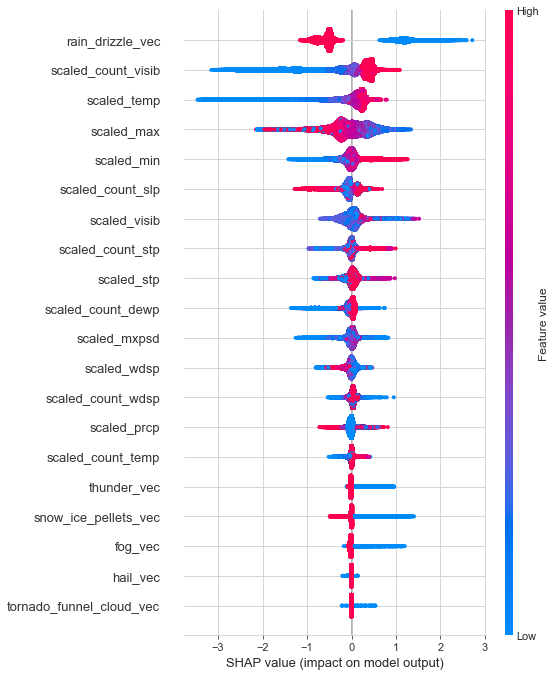

In [43]:
# Summarize the effects of all the features
shap.summary_plot(shap_values, feature_df)